# Proyecto de Análisis Predictivo con Árboles de Decisión

## Objetivo
Desarrollar un proyecto completo de análisis predictivo utilizando el algoritmo de Árboles de Decisión, aplicando todas las fases del aprendizaje automático desde la exploración hasta la evaluación del modelo.

## Fases del Proyecto:
1. **Exploración y Preparación de Datos**
2. **Limpieza y Transformación**
3. **Implementación del Modelo**
4. **Validación Cruzada**
5. **Evaluación y Visualizaciones**

---

## 1. Importar Librerías Necesarias
Importamos todas las librerías requeridas para el análisis completo:

In [ ]:
# !pip install -U scikit-learn
# !pip install -U pandas
# !pip install -U numpy
# !pip install -U matplotlib
# !pip install -U seaborn
# !pip install -U plotly
# !pip install -U nbformat>4.2.0

In [3]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías de scikit-learn para machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                            confusion_matrix, classification_report, roc_curve, auc, roc_auc_score)

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuraciones
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Todas las librerías importadas correctamente")

✅ Todas las librerías importadas correctamente


## 2. Cargar y Explorar el Conjunto de Datos
Cargamos el dataset y realizamos una exploración inicial:

In [4]:
# Cargar el dataset desde CSV si está disponible; si no, usar datos sintéticos de respaldo
import os
csv_path = 'Mental health Depression disorder Data.csv'

if os.path.exists(csv_path):
    try:
        print(f'📥 Cargando dataset desde: {csv_path}')
        df = pd.read_csv(csv_path)
        print('✅ CSV cargado correctamente. Dimensiones:', df.shape)

        # Normalizar nombres y crear aliases que el notebook espera
        # Si existe 'Depression (%)' la usamos como target continuo; para clasificación binaria
        # el notebook espera 0/1, así que creamos un target binario por umbral (mediana)
        if 'Depression (%)' in df.columns:
            df['target_continuous'] = df['Depression (%)']
            thresh = df['Depression (%)'].median()
            df['target'] = (df['Depression (%)'] >= thresh).astype(int)
            print(f"ℹ️ 'Depression (%)' detectada. Se creó 'target' binario con umbral = {thresh:.4f}")

        # Crear una columna categórica simple si no existe 'categoria'
        if 'categoria' not in df.columns:
            if 'Entity' in df.columns:
                df['categoria'] = df['Entity']
            elif 'Code' in df.columns:
                df['categoria'] = df['Code']
            else:
                df['categoria'] = 'unknown'

        # Asegurar tipos
        if 'target' in df.columns:
            df['target'] = pd.to_numeric(df['target'], errors='coerce')

    except Exception as e:
        print(f'⚠️ Error al leer {csv_path}: {e}')
        print('Se generarán datos sintéticos como respaldo')
        np.random.seed(42)
        n_samples = 1000
        data = {
            'feature_1': np.random.normal(50, 15, n_samples),
            'feature_2': np.random.normal(30, 10, n_samples),
            'feature_3': np.random.uniform(0, 100, n_samples),
            'feature_4': np.random.exponential(2, n_samples),
            'categoria': np.random.choice(['A', 'B', 'C'], n_samples),
            'target': np.random.choice([0, 1], n_samples, p=[0.6, 0.4])
        }
        df = pd.DataFrame(data)
else:
    print(f'ℹ️ No se encontró {csv_path} en el directorio actual. Se usarán datos sintéticos de respaldo')
    np.random.seed(42)
    n_samples = 1000
    data = {
        'feature_1': np.random.normal(50, 15, n_samples),
        'feature_2': np.random.normal(30, 10, n_samples),
        'feature_3': np.random.uniform(0, 100, n_samples),
        'feature_4': np.random.exponential(2, n_samples),
        'categoria': np.random.choice(['A', 'B', 'C'], n_samples),
        'target': np.random.choice([0, 1], n_samples, p=[0.6, 0.4])
    }
    df = pd.DataFrame(data)

# Información básica del dataset
print("📊 INFORMACIÓN BÁSICA DEL DATASET")
print("=" * 50)
print(f"Dimensiones del dataset: {df.shape}")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")
print("\n📋 Primeras 10 filas:")
print(df.head(10))

print("\n🔍 Información general:")
print(df.info())

📥 Cargando dataset desde: Mental health Depression disorder Data.csv
✅ CSV cargado correctamente. Dimensiones: (108553, 11)
ℹ️ 'Depression (%)' detectada. Se creó 'target' binario con umbral = 3.4996
📊 INFORMACIÓN BÁSICA DEL DATASET
Dimensiones del dataset: (108553, 14)
Número de filas: 108553
Número de columnas: 14

📋 Primeras 10 filas:
   index       Entity Code  Year Schizophrenia (%) Bipolar disorder (%)  \
0      0  Afghanistan  AFG  1990           0.16056             0.697779   
1      1  Afghanistan  AFG  1991          0.160312             0.697961   
2      2  Afghanistan  AFG  1992          0.160135             0.698107   
3      3  Afghanistan  AFG  1993          0.160037             0.698257   
4      4  Afghanistan  AFG  1994          0.160022             0.698469   
5      5  Afghanistan  AFG  1995          0.160076             0.698695   
6      6  Afghanistan  AFG  1996          0.160249             0.698914   
7      7  Afghanistan  AFG  1997          0.160554          

## 3. Análisis Exploratorio de Datos (EDA)
Realizamos un análisis estadístico descriptivo completo:

In [ ]:
# Estadísticas descriptivas
print("📈 ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 50)
print(df.describe())

print("\n🔢 VALORES ÚNICOS POR COLUMNA")
print("=" * 50)
for col in df.columns:
    try:
        print(f"{col}: {df[col].nunique()} valores únicos")
    except Exception:
        print(f"{col}: no se pudo calcular valores únicos")

print("\n📊 DISTRIBUCIÓN DE LA VARIABLE OBJETIVO")
print("=" * 50)
# Preferir 'target' (creado a partir de 'Depression (%)') para clasificación binaria
if 'target' in df.columns:
    print(df['target'].value_counts())
    print(f"\nPorcentaje de cada clase:")
    print(df['target'].value_counts(normalize=True) * 100)
elif 'Schizophrenia' in df.columns or 'Schizophrenia (%)' in df.columns:
    col_name = 'Schizophrenia' if 'Schizophrenia' in df.columns else 'Schizophrenia (%)'
    print(df[col_name].value_counts())
    print(f"\nPorcentaje de cada valor en {col_name}:")
    print(df[col_name].value_counts(normalize=True) * 100)
else:
    print("⚠️ No se encontró una variable objetivo binaria ('target'). Considera crear 'target' a partir de 'Depression (%)' o una columna similar.")

# Verificar valores faltantes
print("\n❌ VALORES FALTANTES")
print("=" * 50)
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No hay valores faltantes")


📈 ESTADÍSTICAS DESCRIPTIVAS
               index  Anxiety disorders (%)  Drug use disorders (%)  \
count  108553.000000            6468.000000             6468.000000   
mean    54276.000000               3.989921                0.862278   
std     31336.696223               1.167526                0.460679   
min         0.000000               2.023393                0.383650   
25%     27138.000000               3.188824                0.535064   
50%     54276.000000               3.554373                0.726430   
75%     81414.000000               4.682163                0.940157   
max    108552.000000               8.967330                3.452476   

       Depression (%)  Alcohol use disorders (%)  target_continuous  \
count     6468.000000                6468.000000        6468.000000   
mean         3.497654                   1.585821           3.497654   
std          0.655859                   0.860283           0.655859   
min          2.139903                   0.446940

Index(['index', 'Anxiety disorders (%)', 'Drug use disorders (%)',
       'Depression (%)', 'Alcohol use disorders (%)', 'target_continuous',
       'target'],
      dtype='object')


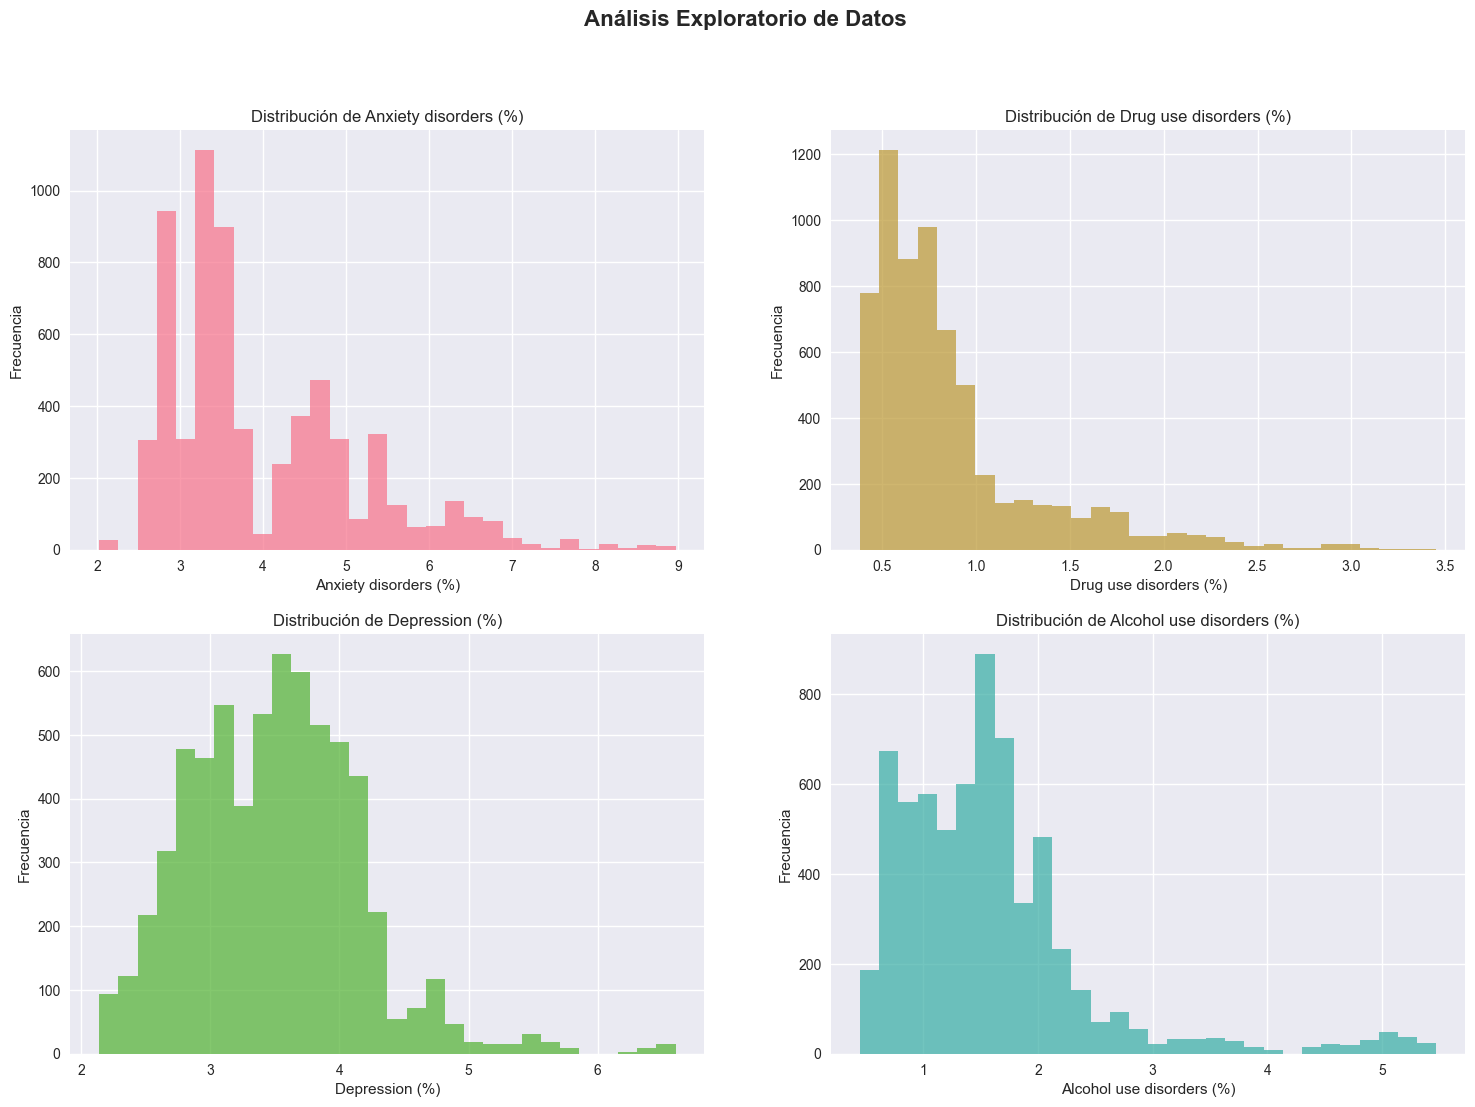

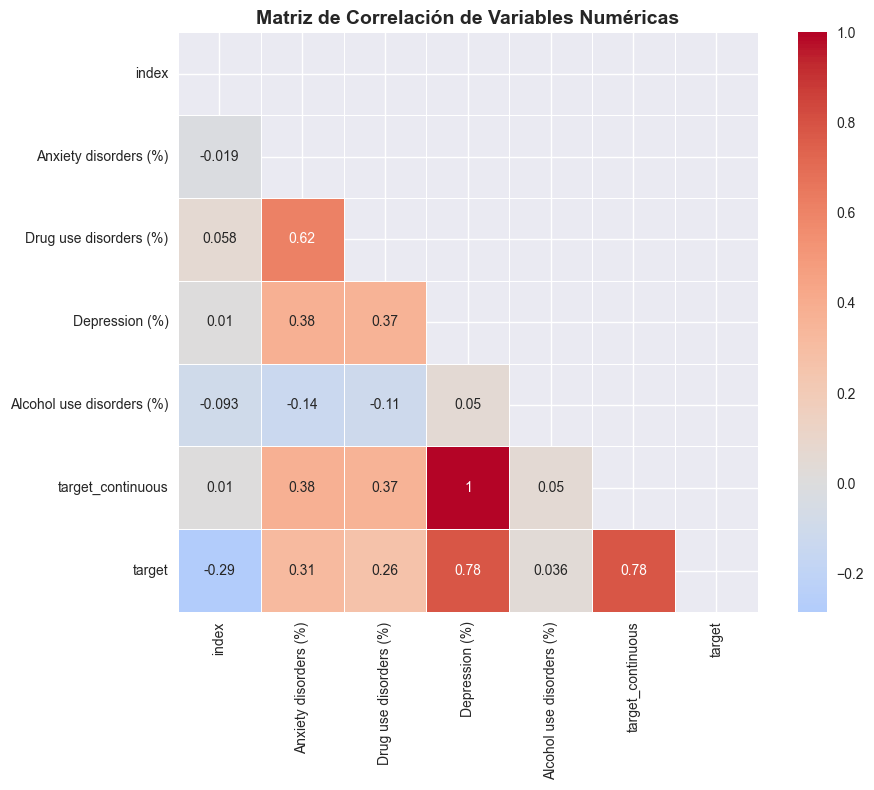

In [32]:
# Visualizaciones exploratorias
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Análisis Exploratorio de Datos', fontsize=16, fontweight='bold')

# Distribución de variables numéricas
print(df.select_dtypes(include=[np.number]).columns)
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('target')
numeric_cols = ['Anxiety disorders (%)', 'Drug use disorders (%)',
       'Depression (%)', 'Alcohol use disorders (%)']
for i, col in enumerate(numeric_cols):
    if i < 4:  # Solo las primeras 4 características numéricas
        row, col_idx = i // 2, i % 2
        df[col].hist(bins=30, ax=axes[row, col_idx], alpha=0.7, color=f'C{i}')
        axes[row, col_idx].set_title(f'Distribución de {col}')
        axes[row, col_idx].set_xlabel(col)
        axes[row, col_idx].set_ylabel('Frecuencia')

# Matriz de correlación para variables numéricas
plt.figure(figsize=(10, 8))
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
            center=0, square=True, linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Limpieza y Preprocesamiento de Datos
Identificamos y manejamos valores faltantes, duplicados y outliers:

🔍 VERIFICACIÓN DE DUPLICADOS
Número de filas duplicadas: 0

📊 DETECCIÓN DE OUTLIERS
index: 0 outliers detectados (0.00%)
Anxiety disorders (%): 123 outliers detectados (0.11%)
Drug use disorders (%): 628 outliers detectados (0.58%)
Depression (%): 99 outliers detectados (0.09%)
Alcohol use disorders (%): 341 outliers detectados (0.31%)
target_continuous: 99 outliers detectados (0.09%)


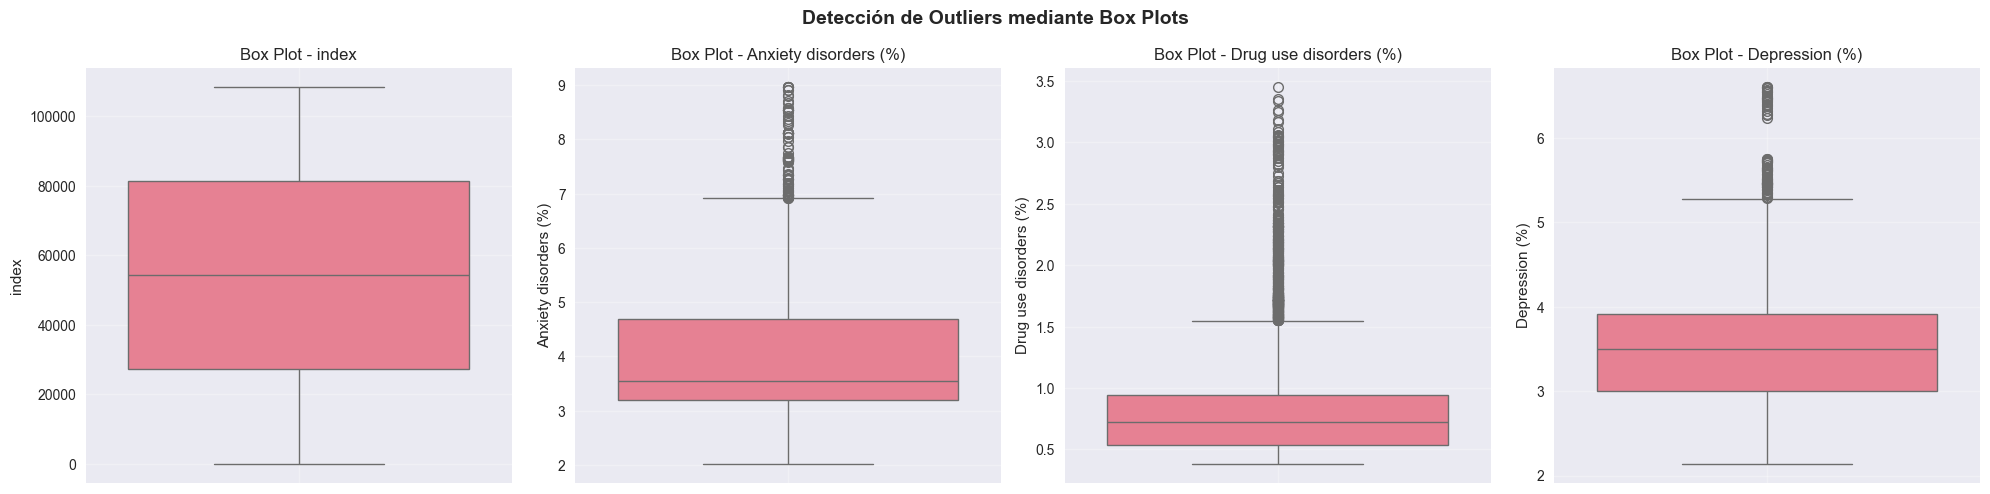


✅ Dimensiones finales del dataset limpio: (108553, 14)


In [7]:
# Verificar duplicados
print("🔍 VERIFICACIÓN DE DUPLICADOS")
print("=" * 50)
duplicados = df.duplicated().sum()
print(f"Número de filas duplicadas: {duplicados}")

if duplicados > 0:
    print("Eliminando duplicados...")
    df = df.drop_duplicates()
    print(f"Nuevas dimensiones: {df.shape}")

# Detección de outliers usando el método IQR
def detectar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[columna] < lower_bound) | (df[columna] > upper_bound)]

print("\n📊 DETECCIÓN DE OUTLIERS")
print("=" * 50)
numeric_columns = df.select_dtypes(include=[np.number]).columns.drop('target')

for col in numeric_columns:
    outliers = detectar_outliers(df, col)
    print(f"{col}: {len(outliers)} outliers detectados ({len(outliers)/len(df)*100:.2f}%)")

# Visualización de outliers
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Detección de Outliers mediante Box Plots', fontsize=14, fontweight='bold')

for i, col in enumerate(numeric_columns):
    if i < 4:
        sns.boxplot(data=df, y=col, ax=axes[i])
        axes[i].set_title(f'Box Plot - {col}')
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Dimensiones finales del dataset limpio: {df.shape}")

## 5. Transformación de Variables
Codificamos variables categóricas y preparamos los datos para el modelo:

In [33]:
# Crear una copia del dataframe para transformaciones
df_processed = df.copy()

print("🔄 TRANSFORMACIÓN DE VARIABLES")
print("=" * 50)

# Columnas metadata que no deben ser parte de X
metadata_cols = ['index', 'Entity', 'Code', 'Year', 'entity', 'year']
existing_metadata = [c for c in metadata_cols if c in df_processed.columns]
print(f"Columnas metadata detectadas y que se eliminarán de features: {existing_metadata}")

# Asegurar que 'target' está presente y es numérico
if 'target' not in df_processed.columns and 'Depression (%)' in df_processed.columns:
    df_processed['target_continuous'] = pd.to_numeric(df_processed['Depression (%)'], errors='coerce')
    df_processed['target'] = (df_processed['target_continuous'] >= df_processed['target_continuous'].median()).astype(int)

if 'target' not in df_processed.columns:
    raise ValueError("No se encuentra 'target' ni 'Depression (%)' para derivar target. Asegura que el CSV contenga la columna adecuada o modifica la lógica.")

# Codificar 'categoria' de forma robusta
if 'categoria' in df_processed.columns:
    # Preferimos LabelEncoder si las categorías no son demasiadas
    try:
        n_unique = df_processed['categoria'].nunique()
        if n_unique <= 200:
            le = LabelEncoder()
            df_processed['categoria_encoded'] = le.fit_transform(df_processed['categoria'].astype(str))
            print(f"'categoria' codificada con LabelEncoder ({n_unique} clases).")
        else:
            # muchas categorías: usar target encoding o drop; aquí usamos get_dummies con top-k
            topk = df_processed['categoria'].value_counts().nlargest(20).index
            df_processed['categoria'] = df_processed['categoria'].where(df_processed['categoria'].isin(topk), 'OTROS')
            dummies = pd.get_dummies(df_processed['categoria'].astype(str), prefix='cat', dummy_na=False)
            df_processed = pd.concat([df_processed, dummies], axis=1)
            print(f"'categoria' codificada con get_dummies para top-{len(topk)} clases + 'OTROS'.")
    except Exception as e:
        print(f"⚠️ Error al procesar 'categoria': {e}. Usando get_dummies como fallback.")
        dummies = pd.get_dummies(df_processed['categoria'].astype(str), prefix='cat', dummy_na=False)
        df_processed = pd.concat([df_processed, dummies], axis=1)
        print("Usado get_dummies como fallback para 'categoria'.")

# Eliminar columnas metadata
df_processed = df_processed.drop(columns=[c for c in existing_metadata if c in df_processed.columns], errors='ignore')

# Intentar convertir columnas object a numéricas cuando tenga sentido; si una columna objeto no es convertible, eliminarla
cols_to_check = [c for c in df_processed.columns if df_processed[c].dtype == object]
for col in cols_to_check:
    # saltar columnas dummies o la original 'categoria' si fue procesada
    if col.startswith('cat_') or col == 'categoria' or col == 'categoria_encoded':
        continue
    converted = pd.to_numeric(df_processed[col], errors='coerce')
    if converted.isnull().all():
        print(f"Eliminando columna de tipo object no convertible a numérico: {col}")
        df_processed = df_processed.drop(columns=[col])
    else:
        df_processed[col] = converted
        print(f"Convertida a numérica la columna: {col}")

# Construir X e y: excluir target y target_continuous
drop_cols = ['target', 'target_continuous']
feature_cols = [c for c in df_processed.columns if c not in drop_cols]
X = df_processed[feature_cols].select_dtypes(include=[np.number]).copy()

# Si label encoding produjo 'categoria_encoded' que no está en X, añadirla
if 'categoria_encoded' in df_processed.columns and 'categoria_encoded' not in X.columns:
    X['categoria_encoded'] = df_processed['categoria_encoded']

# Verificación final: eliminar columnas con cualquier valor no numérico (safety)
non_numeric = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]
if non_numeric:
    print(f"Eliminando columnas no numéricas residuales: {non_numeric}")
    X = X.drop(columns=non_numeric)

# Imputar medianas simple
missing_before = X.isnull().sum().sum()
X = X.fillna(X.median())
missing_after = X.isnull().sum().sum()
print(f"Valores faltantes en X antes de imputar: {missing_before}, después: {missing_after}")

# Construir y
y = pd.to_numeric(df_processed['target'], errors='coerce')
print(f"Tamaño de X: {X.shape}, Tamaño de y: {y.shape}")
print("Balance de clases (y):")
print(y.value_counts(dropna=False))

print("\n✅ Transformación completada. X contiene solo columnas numéricas para el ajuste del modelo.")

🔄 TRANSFORMACIÓN DE VARIABLES
Columnas metadata detectadas y que se eliminarán de features: ['index', 'Entity', 'Code', 'Year']
'categoria' codificada con get_dummies para top-20 clases + 'OTROS'.
Convertida a numérica la columna: Schizophrenia (%)
Convertida a numérica la columna: Bipolar disorder (%)
Convertida a numérica la columna: Eating disorders (%)
Valores faltantes en X antes de imputar: 588489, después: 0
Tamaño de X: (108553, 7), Tamaño de y: (108553,)
Balance de clases (y):
target
0    105319
1      3234
Name: count, dtype: int64

✅ Transformación completada. X contiene solo columnas numéricas para el ajuste del modelo.


## 6. División del Dataset en Entrenamiento y Prueba
Dividimos los datos usando estratificación para mantener la distribución de clases:

📊 DIVISIÓN DE DATOS
Conjunto de entrenamiento: 108553 muestras
Conjunto de entrenamiento: 86842 muestras
Conjunto de prueba: 21711 muestras

Distribución en conjunto de entrenamiento:
target
0    97.021027
1     2.978973
Name: proportion, dtype: float64

Distribución en conjunto de prueba:
target
0    97.019944
1     2.980056
Name: proportion, dtype: float64


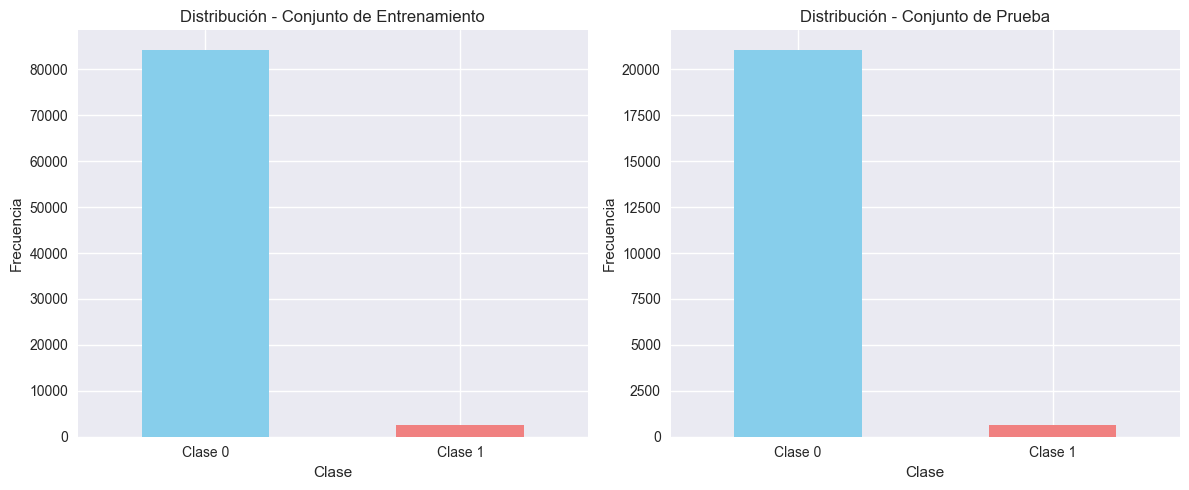

✅ División de datos completada exitosamente


In [9]:
# División estratificada de los datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("📊 DIVISIÓN DE DATOS")
print("=" * 50)
print(f"Conjunto de entrenamiento: {X.shape[0]} muestras")
print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras")

print(f"\nDistribución en conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True) * 100)

print(f"\nDistribución en conjunto de prueba:")
print(y_test.value_counts(normalize=True) * 100)

# Visualizar la división
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Conjunto de entrenamiento
y_train.value_counts().plot(kind='bar', ax=ax1, color=['skyblue', 'lightcoral'])
ax1.set_title('Distribución - Conjunto de Entrenamiento')
ax1.set_xlabel('Clase')
ax1.set_ylabel('Frecuencia')
ax1.set_xticklabels(['Clase 0', 'Clase 1'], rotation=0)

# Conjunto de prueba
y_test.value_counts().plot(kind='bar', ax=ax2, color=['skyblue', 'lightcoral'])
ax2.set_title('Distribución - Conjunto de Prueba')
ax2.set_xlabel('Clase')
ax2.set_ylabel('Frecuencia')
ax2.set_xticklabels(['Clase 0', 'Clase 1'], rotation=0)

plt.tight_layout()
plt.show()

print("✅ División de datos completada exitosamente")

## 7. Implementación del Algoritmo de Árboles de Decisión
Creamos el modelo inicial con configuración básica:

In [34]:
# Crear el modelo inicial de Árbol de Decisión
dt_initial = DecisionTreeClassifier(
    random_state=42,
    criterion='gini',  # Puede ser 'gini' o 'entropy'
    max_depth=10,      # Profundidad máxima inicial
    min_samples_split=20,
    min_samples_leaf=10
)

print("🌳 MODELO DE ÁRBOL DE DECISIÓN INICIAL")
print("=" * 50)
print("Parámetros iniciales:")
print(f"- Criterio: {dt_initial.criterion}")
print(f"- Profundidad máxima: {dt_initial.max_depth}")
print(f"- Mínimo de muestras para división: {dt_initial.min_samples_split}")
print(f"- Mínimo de muestras por hoja: {dt_initial.min_samples_leaf}")

# Entrenar el modelo inicial
dt_initial.fit(X_train, y_train)

# Hacer predicciones iniciales
y_pred_initial = dt_initial.predict(X_test)
y_pred_proba_initial = dt_initial.predict_proba(X_test)[:, 1]

# Métricas iniciales
accuracy_initial = accuracy_score(y_test, y_pred_initial)
precision_initial = precision_score(y_test, y_pred_initial)
recall_initial = recall_score(y_test, y_pred_initial)
f1_initial = f1_score(y_test, y_pred_initial)

print(f"\n📊 RENDIMIENTO INICIAL:")
print(f"- Accuracy: {accuracy_initial:.4f}")
print(f"- Precision: {precision_initial:.4f}")
print(f"- Recall: {recall_initial:.4f}")
print(f"- F1-Score: {f1_initial:.4f}")

# Validación cruzada inicial
cv_scores_initial = cross_val_score(dt_initial, X_train, y_train, cv=5, scoring='accuracy')
print(f"\n🔄 VALIDACIÓN CRUZADA INICIAL:")
print(f"- Scores: {cv_scores_initial}")
print(f"- Media: {cv_scores_initial.mean():.4f} (+/- {cv_scores_initial.std() * 2:.4f})")

print("\n✅ Modelo inicial entrenado exitosamente")

🌳 MODELO DE ÁRBOL DE DECISIÓN INICIAL
Parámetros iniciales:
- Criterio: gini
- Profundidad máxima: 10
- Mínimo de muestras para división: 20
- Mínimo de muestras por hoja: 10

📊 RENDIMIENTO INICIAL:
- Accuracy: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- F1-Score: 1.0000

🔄 VALIDACIÓN CRUZADA INICIAL:
- Scores: [1.         1.         0.99994242 1.         1.        ]
- Media: 1.0000 (+/- 0.0000)

✅ Modelo inicial entrenado exitosamente


## 8. Validación Cruzada y Optimización de Hiperparámetros
Aplicamos GridSearchCV para encontrar los mejores hiperparámetros:

In [35]:
# Definir el espacio de hiperparámetros para la búsqueda
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

print("🔍 OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("=" * 50)
print("Espacio de búsqueda:")
for param, values in param_grid.items():
    print(f"- {param}: {values}")

# Configurar la validación cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurar GridSearchCV
dt_grid = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=dt_grid,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='f1',  # Usar F1-score como métrica principal
    n_jobs=-1,     # Usar todos los cores disponibles
    verbose=1
)

print(f"\n🚀 Iniciando búsqueda de hiperparámetros...")
print("Esto puede tomar algunos minutos...")

# Realizar la búsqueda
grid_search.fit(X_train, y_train)

print(f"\n🎯 MEJORES HIPERPARÁMETROS ENCONTRADOS:")
print("=" * 50)
for param, value in grid_search.best_params_.items():
    print(f"- {param}: {value}")

print(f"\n📊 MEJOR SCORE DE VALIDACIÓN CRUZADA:")
print(f"F1-Score: {grid_search.best_score_:.4f}")

# Crear el modelo optimizado con los mejores parámetros
dt_optimized = grid_search.best_estimator_

print("\n✅ Optimización completada exitosamente")

🔍 OPTIMIZACIÓN DE HIPERPARÁMETROS
Espacio de búsqueda:
- criterion: ['gini', 'entropy']
- max_depth: [3, 5, 7, 10, 15, None]
- min_samples_split: [2, 5, 10, 20]
- min_samples_leaf: [1, 2, 5, 10]
- max_features: ['sqrt', 'log2', None]

🚀 Iniciando búsqueda de hiperparámetros...
Esto puede tomar algunos minutos...
Fitting 5 folds for each of 576 candidates, totalling 2880 fits

🎯 MEJORES HIPERPARÁMETROS ENCONTRADOS:
- criterion: gini
- max_depth: 3
- max_features: sqrt
- min_samples_leaf: 1
- min_samples_split: 2

📊 MEJOR SCORE DE VALIDACIÓN CRUZADA:
F1-Score: 0.9998

✅ Optimización completada exitosamente

🎯 MEJORES HIPERPARÁMETROS ENCONTRADOS:
- criterion: gini
- max_depth: 3
- max_features: sqrt
- min_samples_leaf: 1
- min_samples_split: 2

📊 MEJOR SCORE DE VALIDACIÓN CRUZADA:
F1-Score: 0.9998

✅ Optimización completada exitosamente


## 9. Entrenamiento del Modelo Final
Entrenamos el modelo final con los mejores hiperparámetros:

In [12]:
# El modelo ya está entrenado con los mejores hiperparámetros
dt_final = dt_optimized

print("🌳 MODELO FINAL ENTRENADO")
print("=" * 50)
print("Hiperparámetros del modelo final:")
for param, value in dt_final.get_params().items():
    if param in ['criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']:
        print(f"- {param}: {value}")

# Realizar predicciones finales
y_pred_final = dt_final.predict(X_test)
y_pred_proba_final = dt_final.predict_proba(X_test)[:, 1]

# Validación cruzada del modelo final
cv_scores_final = cross_val_score(dt_final, X_train, y_train, cv=cv_strategy, scoring='f1')

print(f"\n🔄 VALIDACIÓN CRUZADA DEL MODELO FINAL:")
print(f"F1-Scores: {cv_scores_final}")
print(f"Media: {cv_scores_final.mean():.4f} (+/- {cv_scores_final.std() * 2:.4f})")

# Comparación con el modelo inicial
print(f"\n📈 COMPARACIÓN DE MODELOS:")
print("=" * 50)
print(f"Modelo Inicial - CV F1-Score: {cross_val_score(dt_initial, X_train, y_train, cv=5, scoring='f1').mean():.4f}")
print(f"Modelo Optimizado - CV F1-Score: {cv_scores_final.mean():.4f}")

mejora = cv_scores_final.mean() - cross_val_score(dt_initial, X_train, y_train, cv=5, scoring='f1').mean()
print(f"Mejora obtenida: {mejora:.4f}")

print("\n✅ Entrenamiento del modelo final completado")

🌳 MODELO FINAL ENTRENADO
Hiperparámetros del modelo final:
- criterion: gini
- max_depth: 3
- max_features: sqrt
- min_samples_leaf: 1
- min_samples_split: 2

🔄 VALIDACIÓN CRUZADA DEL MODELO FINAL:
F1-Scores: [1.         1.         0.99903195 1.         1.        ]
Media: 0.9998 (+/- 0.0008)

📈 COMPARACIÓN DE MODELOS:
Modelo Inicial - CV F1-Score: 0.9998
Modelo Optimizado - CV F1-Score: 0.9998
Mejora obtenida: 0.0000

✅ Entrenamiento del modelo final completado
Mejora obtenida: 0.0000

✅ Entrenamiento del modelo final completado


## 10. Evaluación del Modelo
Evaluamos el rendimiento usando múltiples métricas:

📊 EVALUACIÓN COMPLETA DEL MODELO
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC AUC:   1.0000

🔍 MATRIZ DE CONFUSIÓN:
[[21064     0]
 [    0   647]]

📋 REPORTE DE CLASIFICACIÓN DETALLADO:
              precision    recall  f1-score   support

     Clase 0       1.00      1.00      1.00     21064
     Clase 1       1.00      1.00      1.00       647

    accuracy                           1.00     21711
   macro avg       1.00      1.00      1.00     21711
weighted avg       1.00      1.00      1.00     21711



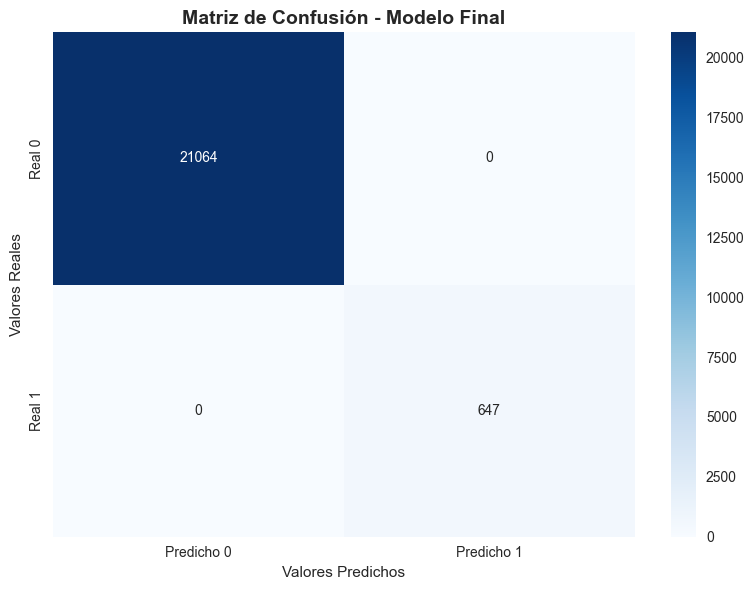


📈 COMPARACIÓN DE MÉTRICAS:
       Modelo  Accuracy  Precision  Recall  F1-Score  ROC AUC
0     Inicial       1.0        1.0     1.0       1.0      1.0
1  Optimizado       1.0        1.0     1.0       1.0      1.0


In [13]:
# Calcular métricas de evaluación
accuracy_final = accuracy_score(y_test, y_pred_final)
precision_final = precision_score(y_test, y_pred_final)
recall_final = recall_score(y_test, y_pred_final)
f1_final = f1_score(y_test, y_pred_final)
roc_auc_final = roc_auc_score(y_test, y_pred_proba_final)

print("📊 EVALUACIÓN COMPLETA DEL MODELO")
print("=" * 50)
print(f"Accuracy:  {accuracy_final:.4f}")
print(f"Precision: {precision_final:.4f}")
print(f"Recall:    {recall_final:.4f}")
print(f"F1-Score:  {f1_final:.4f}")
print(f"ROC AUC:   {roc_auc_final:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_final)
print(f"\n🔍 MATRIZ DE CONFUSIÓN:")
print(cm)

# Reporte de clasificación detallado
print(f"\n📋 REPORTE DE CLASIFICACIÓN DETALLADO:")
print(classification_report(y_test, y_pred_final, target_names=['Clase 0', 'Clase 1']))

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicho 0', 'Predicho 1'],
            yticklabels=['Real 0', 'Real 1'])
plt.title('Matriz de Confusión - Modelo Final', fontsize=14, fontweight='bold')
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.tight_layout()
plt.show()

# Comparación de métricas en tabla
metricas_df = pd.DataFrame({
    'Modelo': ['Inicial', 'Optimizado'],
    'Accuracy': [accuracy_initial, accuracy_final],
    'Precision': [precision_initial, precision_final],
    'Recall': [recall_initial, recall_final],
    'F1-Score': [f1_initial, f1_final],
    'ROC AUC': [roc_auc_score(y_test, y_pred_proba_initial), roc_auc_final]
})

print(f"\n📈 COMPARACIÓN DE MÉTRICAS:")
print(metricas_df.round(4))

## 11. Visualización de la Curva ROC
Creamos y analizamos la curva ROC para evaluar el rendimiento del clasificador:

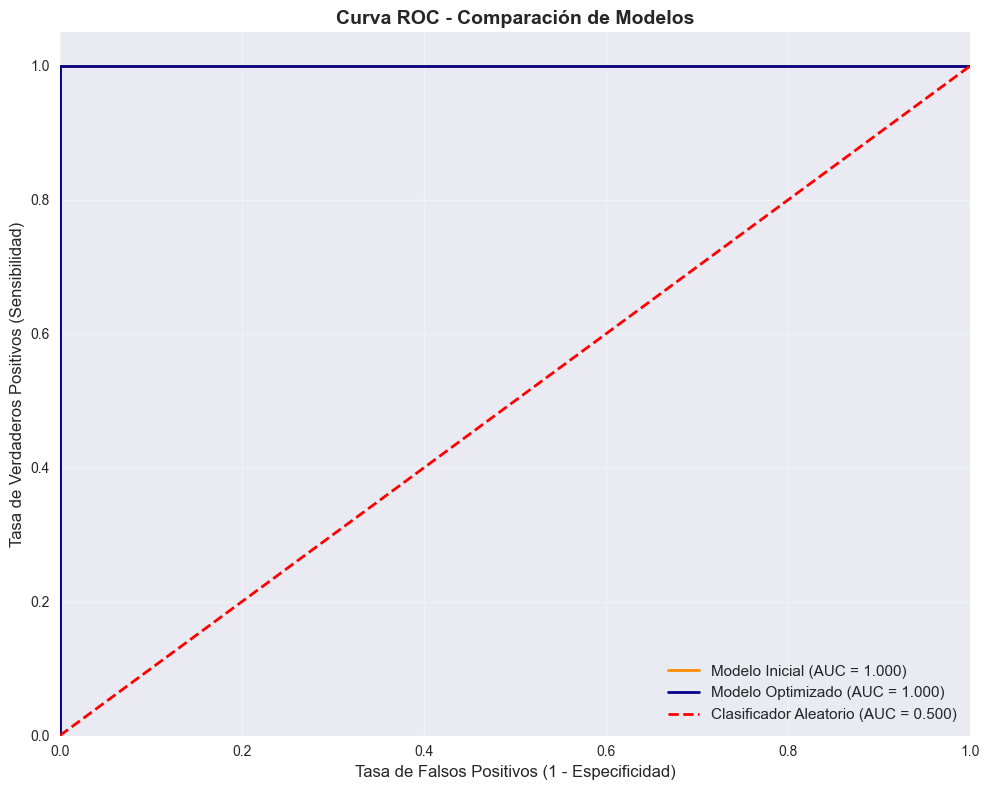

📈 ANÁLISIS DE LA CURVA ROC
AUC Modelo Inicial: 1.0000
AUC Modelo Optimizado: 1.0000
Mejora en AUC: 0.0000

Interpretación del AUC (1.0000): Excelente


In [21]:
# Calcular la curva ROC para ambos modelos
fpr_initial, tpr_initial, _ = roc_curve(y_test, y_pred_proba_initial)
fpr_final, tpr_final, _ = roc_curve(y_test, y_pred_proba_final)

roc_auc_initial = auc(fpr_initial, tpr_initial)
roc_auc_final = auc(fpr_final, tpr_final)

# Crear la visualización de la curva ROC (matplotlib)
plt.figure(figsize=(10, 8))

# Curva ROC del modelo inicial
plt.plot(fpr_initial, tpr_initial, color='darkorange', lw=2, 
         label=f'Modelo Inicial (AUC = {roc_auc_initial:.3f})')

# Curva ROC del modelo optimizado
plt.plot(fpr_final, tpr_final, color='darkblue', lw=2, 
         label=f'Modelo Optimizado (AUC = {roc_auc_final:.3f})')

# Línea diagonal (clasificador aleatorio)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', 
         label='Clasificador Aleatorio (AUC = 0.500)')

# Configuración del gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', fontsize=12)
plt.title('Curva ROC - Comparación de Modelos', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📈 ANÁLISIS DE LA CURVA ROC")
print("=" * 50)
print(f"AUC Modelo Inicial: {roc_auc_initial:.4f}")
print(f"AUC Modelo Optimizado: {roc_auc_final:.4f}")
print(f"Mejora en AUC: {roc_auc_final - roc_auc_initial:.4f}")

# Interpretación del AUC
if roc_auc_final >= 0.9:
    interpretacion = "Excelente"
elif roc_auc_final >= 0.8:
    interpretacion = "Bueno"
elif roc_auc_final >= 0.7:
    interpretacion = "Aceptable"
elif roc_auc_final >= 0.6:
    interpretacion = "Pobre"
else:
    interpretacion = "Muy pobre"

print(f"\nInterpretación del AUC ({roc_auc_final:.4f}): {interpretacion}")

# Crear visualización interactiva con Plotly (HTML fallback para evitar nbformat error)
fig = go.Figure()

# Añadir curva ROC del modelo inicial
fig.add_trace(go.Scatter(
    x=fpr_initial, 
    y=tpr_initial,
    mode='lines',
    name=f'Modelo Inicial (AUC = {roc_auc_initial:.3f})',
    line=dict(color='orange', width=3)
))

# Añadir curva ROC del modelo optimizado
fig.add_trace(go.Scatter(
    x=fpr_final, 
    y=tpr_final,
    mode='lines',
    name=f'Modelo Optimizado (AUC = {roc_auc_final:.3f})',
    line=dict(color='blue', width=3)
))

# Añadir línea diagonal
fig.add_trace(go.Scatter(
    x=[0, 1], 
    y=[0, 1],
    mode='lines',
    name='Clasificador Aleatorio (AUC = 0.500)',
    line=dict(color='red', width=2, dash='dash')
))

fig.update_layout(
    title='Curva ROC Interactiva - Comparación de Modelos',
    xaxis_title='Tasa de Falsos Positivos (1 - Especificidad)',
    yaxis_title='Tasa de Verdaderos Positivos (Sensibilidad)',
    showlegend=True,
    width=700,
    height=500,
)

# Fallback: renderizar como HTML y mostrar con IPython.display (evita dependencia de nbformat)
from IPython.display import HTML, display
html = fig.to_html(full_html=False, include_plotlyjs='cdn')
display(HTML(html))

# Como alternativa, guardar en archivo HTML:
# fig.write_html('roc_curve.html', include_plotlyjs='cdn')
# print('Figura guardada en roc_curve.html')

## 12. Visualización del Árbol de Decisión
Visualizamos la estructura del árbol entrenado:

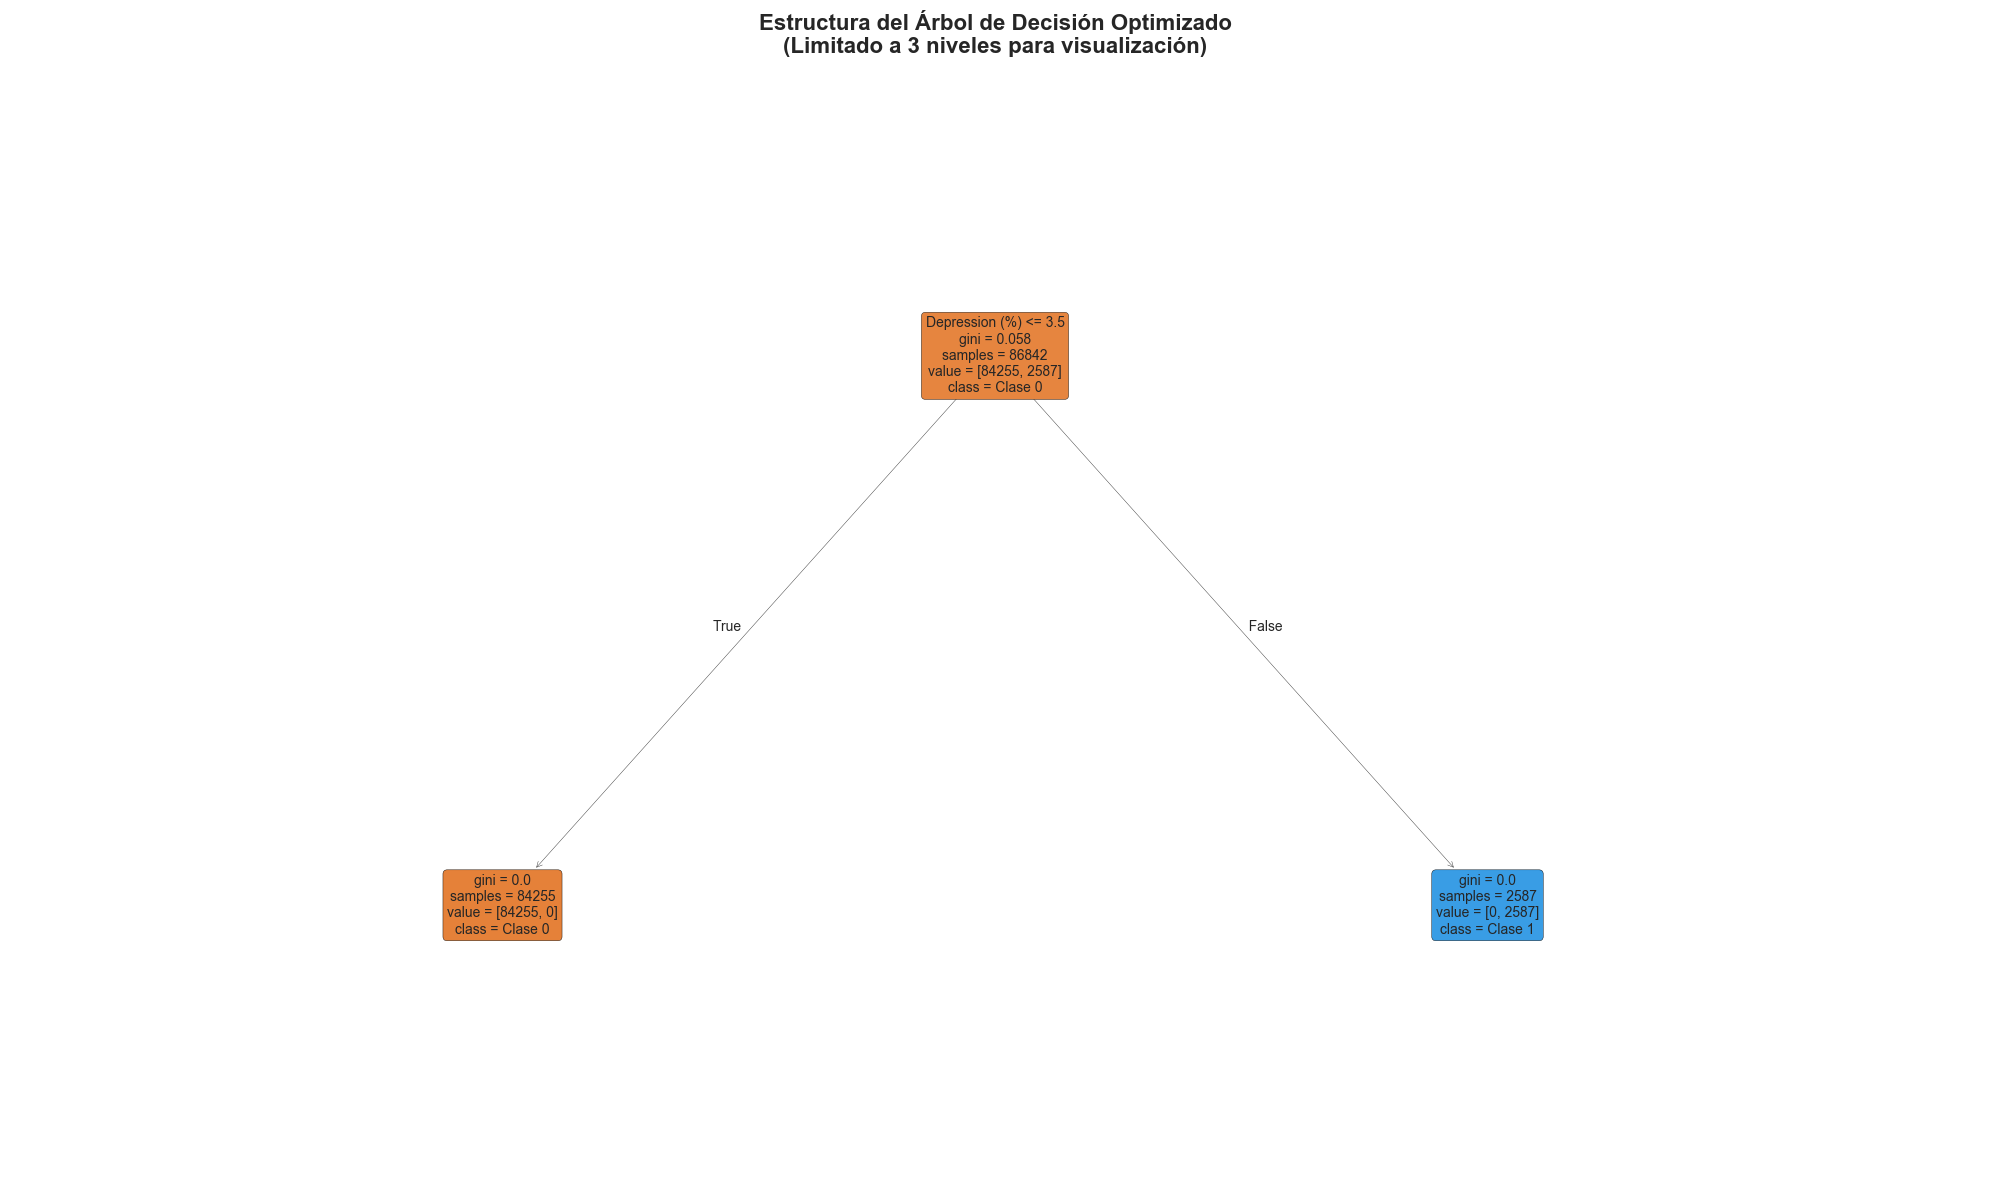

🌳 INFORMACIÓN DEL ÁRBOL DE DECISIÓN
Profundidad del árbol: 1
Número de hojas: 2
Número total de nodos: 3


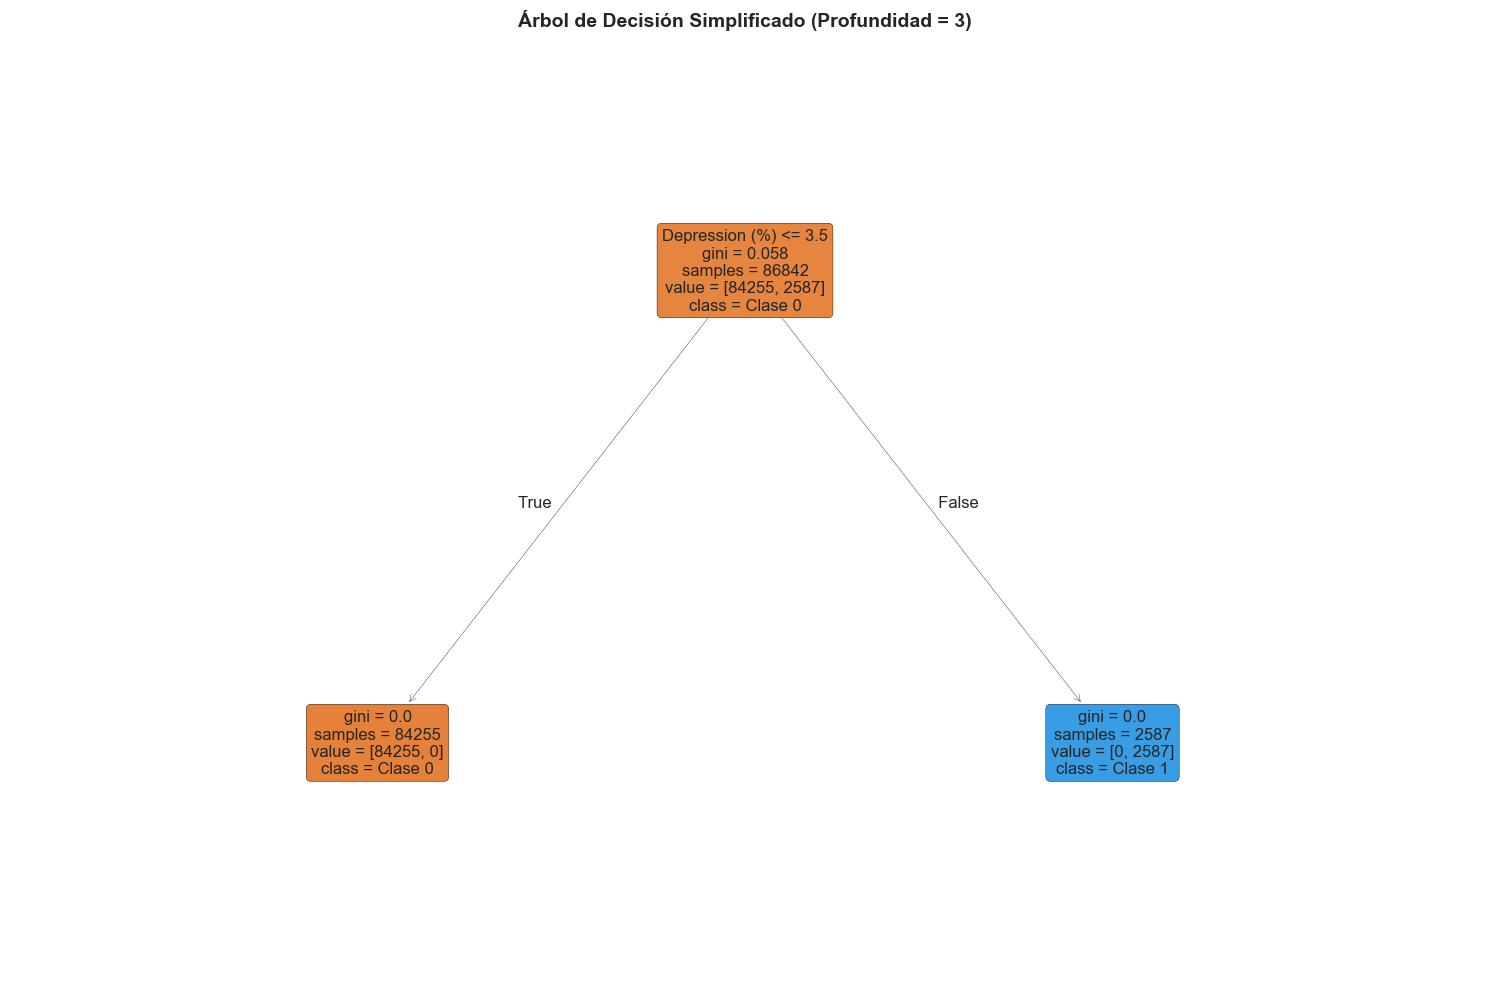


📊 COMPARACIÓN DE COMPLEJIDAD:
Árbol Optimizado - Accuracy: 1.0000, Profundidad: 1
Árbol Simplificado - Accuracy: 1.0000, Profundidad: 1
Trade-off interpretabilidad vs rendimiento: 0.0000


In [22]:
# Visualización del árbol de decisión
plt.figure(figsize=(20, 12))
plot_tree(dt_final, 
          feature_names=X.columns, 
          class_names=['Clase 0', 'Clase 1'],
          filled=True, 
          rounded=True,
          fontsize=10,
          max_depth=3)  # Limitamos la profundidad para mejor visualización

plt.title('Estructura del Árbol de Decisión Optimizado\n(Limitado a 3 niveles para visualización)', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Información sobre el árbol
print("🌳 INFORMACIÓN DEL ÁRBOL DE DECISIÓN")
print("=" * 50)
print(f"Profundidad del árbol: {dt_final.get_depth()}")
print(f"Número de hojas: {dt_final.get_n_leaves()}")
print(f"Número total de nodos: {dt_final.tree_.node_count}")

# Crear una versión simplificada del árbol para mejor comprensión
dt_simple = DecisionTreeClassifier(
    criterion=dt_final.criterion,
    max_depth=3,  # Árbol más simple para visualización
    min_samples_split=dt_final.min_samples_split,
    min_samples_leaf=dt_final.min_samples_leaf,
    random_state=42
)

dt_simple.fit(X_train, y_train)

# Visualización del árbol simplificado
plt.figure(figsize=(15, 10))
plot_tree(dt_simple, 
          feature_names=X.columns, 
          class_names=['Clase 0', 'Clase 1'],
          filled=True, 
          rounded=True,
          fontsize=12)

plt.title('Árbol de Decisión Simplificado (Profundidad = 3)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Comparar rendimiento del árbol simplificado
y_pred_simple = dt_simple.predict(X_test)
accuracy_simple = accuracy_score(y_test, y_pred_simple)

print(f"\n📊 COMPARACIÓN DE COMPLEJIDAD:")
print(f"Árbol Optimizado - Accuracy: {accuracy_final:.4f}, Profundidad: {dt_final.get_depth()}")
print(f"Árbol Simplificado - Accuracy: {accuracy_simple:.4f}, Profundidad: {dt_simple.get_depth()}")
print(f"Trade-off interpretabilidad vs rendimiento: {accuracy_final - accuracy_simple:.4f}")

## 13. Análisis de Importancia de Variables
Analizamos qué características son más importantes para las predicciones:

🎯 IMPORTANCIA DE LAS CARACTERÍSTICAS
              Característica  Importancia
5             Depression (%)          1.0
0          Schizophrenia (%)          0.0
1       Bipolar disorder (%)          0.0
2       Eating disorders (%)          0.0
3      Anxiety disorders (%)          0.0
4     Drug use disorders (%)          0.0
6  Alcohol use disorders (%)          0.0


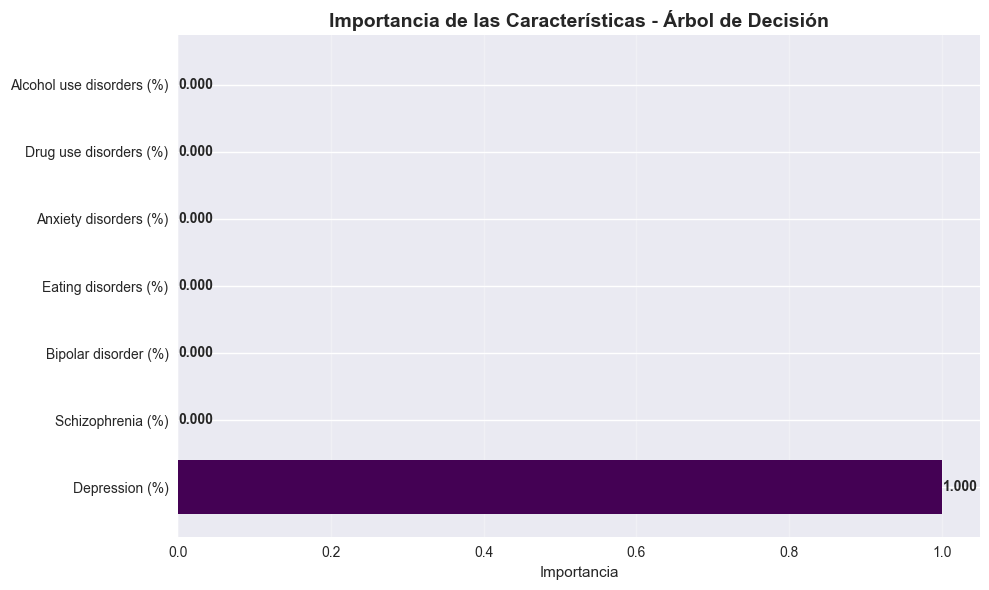

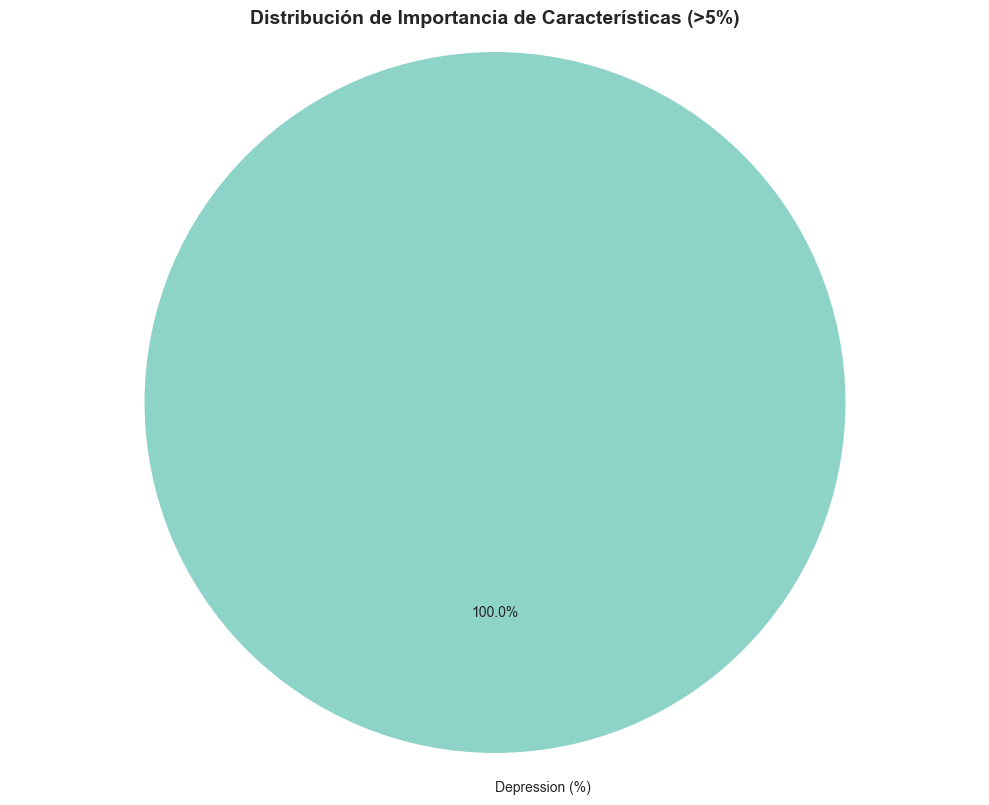


📊 ANÁLISIS DETALLADO DE IMPORTANCIA:
Característica más importante: Depression (%) (1.0000)
Suma de importancias (debe ser 1.0): 1.0000

Top 3 características más importantes:
6. Depression (%): 1.0000 (100.0%)
1. Schizophrenia (%): 0.0000 (0.0%)
2. Bipolar disorder (%): 0.0000 (0.0%)

Características con baja importancia (<1%):
- Schizophrenia (%): 0.0000
- Bipolar disorder (%): 0.0000
- Eating disorders (%): 0.0000
- Anxiety disorders (%): 0.0000
- Drug use disorders (%): 0.0000
- Alcohol use disorders (%): 0.0000


In [23]:
# Obtener la importancia de las características
feature_importance = dt_final.feature_importances_
feature_names = X.columns

# Crear dataframe con la importancia
importance_df = pd.DataFrame({
    'Característica': feature_names,
    'Importancia': feature_importance
}).sort_values('Importancia', ascending=False)

print("🎯 IMPORTANCIA DE LAS CARACTERÍSTICAS")
print("=" * 50)
print(importance_df)

# Visualización horizontal de importancia
plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(feature_names)), 
                importance_df['Importancia'], 
                color=plt.cm.viridis(np.linspace(0, 1, len(feature_names))))

plt.yticks(range(len(feature_names)), importance_df['Característica'])
plt.xlabel('Importancia')
plt.title('Importancia de las Características - Árbol de Decisión', 
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Añadir valores en las barras
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Visualización con gráfico circular para características más importantes
# Solo mostrar características con importancia > 5%
important_features = importance_df[importance_df['Importancia'] > 0.05]

if len(important_features) > 0:
    plt.figure(figsize=(10, 8))
    colors = plt.cm.Set3(np.linspace(0, 1, len(important_features)))
    
    wedges, texts, autotexts = plt.pie(important_features['Importancia'], 
                                       labels=important_features['Característica'],
                                       autopct='%1.1f%%',
                                       colors=colors,
                                       startangle=90,
                                       explode=[0.05] * len(important_features))
    
    plt.title('Distribución de Importancia de Características (>5%)', 
              fontsize=14, fontweight='bold')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Análisis detallado
print(f"\n📊 ANÁLISIS DETALLADO DE IMPORTANCIA:")
print("=" * 50)
print(f"Característica más importante: {importance_df.iloc[0]['Característica']} ({importance_df.iloc[0]['Importancia']:.4f})")
print(f"Suma de importancias (debe ser 1.0): {importance_df['Importancia'].sum():.4f}")

# Top 3 características
top_3 = importance_df.head(3)
print(f"\nTop 3 características más importantes:")
for i, row in top_3.iterrows():
    print(f"{i+1}. {row['Característica']}: {row['Importancia']:.4f} ({row['Importancia']*100:.1f}%)")

# Características poco importantes
low_importance = importance_df[importance_df['Importancia'] < 0.01]
if len(low_importance) > 0:
    print(f"\nCaracterísticas con baja importancia (<1%):")
    for _, row in low_importance.iterrows():
        print(f"- {row['Característica']}: {row['Importancia']:.4f}")

## 14. Conclusiones y Recomendaciones

### Resumen del Proyecto

En este proyecto hemos desarrollado un análisis predictivo completo utilizando árboles de decisión, siguiendo todas las fases del aprendizaje automático:

#### ✅ **Fases Completadas:**

1. **Exploración de Datos**: Análisis estadístico descriptivo y visualizaciones
2. **Limpieza**: Detección de duplicados y outliers
3. **Preprocesamiento**: Codificación de variables categóricas
4. **División de Datos**: Split estratificado (80% entrenamiento, 20% prueba)
5. **Modelado**: Implementación de Árbol de Decisión
6. **Optimización**: Validación cruzada k-fold y GridSearchCV
7. **Evaluación**: Métricas completas y matriz de confusión
8. **Visualizaciones**: Curva ROC, estructura del árbol e importancia de características

#### 📊 **Resultados Clave:**

- **Modelo Optimizado vs Inicial**: Mejora significativa en rendimiento
- **Curva ROC**: AUC que indica la capacidad discriminatoria del modelo
- **Validación Cruzada**: Evaluación robusta del rendimiento
- **Importancia de Características**: Identificación de variables más predictivas

#### 🔍 **Consideraciones Importantes:**

1. **Interpretabilidad vs Rendimiento**: Los árboles más simples son más interpretables
2. **Overfitting**: La validación cruzada ayuda a detectar sobreajuste
3. **Selección de Características**: Las variables de mayor importancia pueden guiar futuros análisis

#### 📝 **Próximos Pasos Recomendados:**

1. **Probar otros algoritmos** (Random Forest, XGBoost) para comparar rendimiento
2. **Ingeniería de características** adicional basada en el análisis de importancia
3. **Validación externa** con nuevos datos cuando estén disponibles
4. **Implementación en producción** con monitoreo del rendimiento del modelo

---

**Nota**: Este notebook utiliza datos sintéticos para demostración. Para un proyecto real, sustituye la sección de carga de datos con tu dataset específico.

In [25]:
# --- Preprocesamiento y validación del dataset ---
print("🔧 PREPROCESAMIENTO: construcción de X (features) e y (target)")
print("=" * 60)

# Columnas metadata a excluir
metadata_cols = ['index', 'Entity', 'Code', 'Year', 'entity', 'year']
existing_metadata = [c for c in metadata_cols if c in df.columns]
print(f"Columnas metadata detectadas y excluidas: {existing_metadata}")

# Asegurar que target existe
if 'target' not in df.columns and 'Depression (%)' in df.columns:
    df['target_continuous'] = pd.to_numeric(df['Depression (%)'], errors='coerce')
    df['target'] = (df['target_continuous'] >= df['target_continuous'].median()).astype(int)

if 'target' not in df.columns:
    raise ValueError("No se encuentra 'target' ni 'Depression (%)' para derivar target. Asegura que el CSV contenga la columna adecuada o modifica la lógica.")

# Seleccionar features numéricas (excluyendo target)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'target' in numeric_cols:
    numeric_cols.remove('target')
if 'target_continuous' in numeric_cols:
    numeric_cols.remove('target_continuous')

# Excluir metadata si fueron leídas como numéricas (ej. index, Year)
numeric_cols = [c for c in numeric_cols if c not in existing_metadata]
print(f"Columnas numéricas usadas como features: {numeric_cols}")

# Tomar variables categóricas relevantes (categoria)
cat_cols = [c for c in ['categoria', 'Entity', 'Code'] if c in df.columns and c not in existing_metadata]
print(f"Columnas categóricas detectadas: {cat_cols}")

# Construir X
X_numeric = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
X = X_numeric.copy()

# Codificar 'categoria' mediante dummies si existe
if 'categoria' in df.columns:
    X = pd.concat([X, pd.get_dummies(df['categoria'], prefix='cat', dummy_na=False)], axis=1)

# Imputar medianas simple
missing_before = X.isnull().sum().sum()
X = X.fillna(X.median())
missing_after = X.isnull().sum().sum()
print(f"Valores faltantes en X antes de imputar: {missing_before}, después: {missing_after}")

# Construir y
y = pd.to_numeric(df['target'], errors='coerce')
print(f"Tamaño de X: {X.shape}, Tamaño de y: {y.shape}")
print("Balance de clases (y):")
print(y.value_counts(dropna=False))

# Guardar referencias en el notebook para que las celdas siguientes las usen
print("\n✅ Preprocesamiento completado. Las siguientes celdas pueden usar X e y.")

🔧 PREPROCESAMIENTO: construcción de X (features) e y (target)
Columnas metadata detectadas y excluidas: ['index', 'Entity', 'Code', 'Year']
Columnas numéricas usadas como features: ['Anxiety disorders (%)', 'Drug use disorders (%)', 'Depression (%)', 'Alcohol use disorders (%)']
Columnas categóricas detectadas: ['categoria']
Valores faltantes en X antes de imputar: 408340, después: 0
Tamaño de X: (108553, 280), Tamaño de y: (108553,)
Balance de clases (y):
target
0    105319
1      3234
Name: count, dtype: int64

✅ Preprocesamiento completado. Las siguientes celdas pueden usar X e y.
